In [1]:
import pandas as pd
import numpy as np
import kaggle
import re

# 1. COLETA

### Web Scraping 

```$ python3 extracting_tvshows_status.py```

In [2]:

df_metacritic = pd.read_csv('status/metacritic.csv')
# Dados extradios do site Metacritic

### Kaggle Datasets

In [3]:
kaggle.api.authenticate()

# https://www.kaggle.com/oscarfry/tvtime-shows?select=tvtimeshows.csv
kaggle.api.dataset_download_files('oscarfry/tvtime-shows', path='./data/tvtimeshows', unzip = True)

# https://www.kaggle.com/ruchi798/tv-shows-on-netflix-prime-video-hulu-and-disney 
kaggle.api.dataset_download_files('ruchi798/tv-shows-on-netflix-prime-video-hulu-and-disney', path='./data/streamings', unzip = True)

# https://www.kaggle.com/unanimad/emmy-awards
kaggle.api.dataset_download_files('unanimad/emmy-awards', path='./data/awards', unzip = True)

# https://www.kaggle.com/unanimad/golden-globe-awards
kaggle.api.dataset_download_files('unanimad/golden-globe-awards', path='./data/awards' , unzip = True)

In [3]:
df_tvtime = pd.read_csv('data/tvtimeshows/tvtimeshows.csv')
# df_tvtime.head()

df_streamings = pd.read_csv('data/streamings/tv_shows.csv')
# df_streamings.head()

df_award_emmy = pd.read_csv('data/awards/the_emmy_awards.csv')
# df_award_emmy.head()

df_award_goldenglobe = pd.read_csv('data/awards/golden_globe_awards.csv')
# df_award_goldenglobe.head()

# PRÉ-PROCESSAMENTO

## Processando os dados do metacritcs

O DataFrame `df_metacritcs` é fruto da extração de dados de um site que mostra qual o status das séries em cada ano, entre 2013 e 2020

O código a seguir processa esses dados filtrando as redes mais populares, inferindo o status a partir do texto encontrado no site e juntando os dados capturados em cada ano em uma informação única para cada série

Estas operações resultam no DataFrame `df_metacritic_aggregated`

In [4]:
def filter_networks(df_tt, networks): 
    column_names = list(df_tt.columns)
    df_most_popular = pd.DataFrame(columns = column_names)
    for i in networks:
        df = df_tt[df_tt['tv_network'].str.contains(i, flags=re.IGNORECASE, regex=True, na=False)]
        df['tv_network'] = i
        df_most_popular = df_most_popular.append(df,ignore_index=True)
    return df_most_popular

In [5]:
# filtrar dados somente de redes de TV populares

popular_networks = [ "ABC", "CBS", "NBC", "NETFLIX", "AMAZON", "DISNEY", "HULU", "HBO", "APPLE", "FOX", "MTV",'FX','SYFY','THE CW','FREEF','TNT','IFC','STRZ','TVL','SHOWTIME','AMC','USA', "TBS", "YHOO", "YT"]

df_metacritic_popular_networks = filter_networks(df_metacritic, popular_networks)

In [6]:
# infere a 'categoria' do status a partir do texto encontrado no site
def standardize_status(df): 
    column_names = list(df.columns)
    column_names.append('changed_network')
    df_clean = pd.DataFrame(columns = column_names)
    df_clean = df.copy()
    df_clean['changed_network'] = False

    dict_status = {
       'canceled' : ['CANCELED','order rescinded','Likely to end','won\'t air','Pulled from schedule','Cancellation','not return','not be moving forward', 'won\'t be back', 'No plans', 'not progressing', 'killed', 'not on schedule', 'season unlikely', 'Postponed indefinitely', 'Production halted', r'not included in .* plans', 'pulled from  schedule', 'pulled out'],
       'renewed' : ['Renew','order',r'S(\d+) confirmed','return on', 'returns on','Renwed', 'in production', 'in development', 'will air', r'S(\d+) announced', 'revival', 'returns later', 'will likely return', 'season in', 'to air', 'season announced'],
       'renewed_but' : ['Moved to', 'Moving from', "Moving to", 'Moves to', 'moved from','Moved from', 'will move to', 'Moving back to', 'picked up'],
       'delayed' : ['delayed', 'delay'],
       'end' : ['Ending','ended', 'Final season','miniseries', 'concluding with', 'will end with', '1-season show', 'last aired', 'miniseres'],
       'animated' : ['animated','anime'],
       'nacionality':  ['Brazilian' , 'Spanish', 'German', 'Korean', 'Japanese', 'Swedish', 'French', 'Argentinian', 'Austalian', 'British', 'Belgian', 'Polish', 'Chinese', 'Italian', 'Mexican', 'Indian', 'Colombian', 'Thai', 'Taiwanese', 'Turkish', 'Norwegian', 'Lebanese', 'Israeli', 'Arabic', 'Dutch', 'Argentine','UK','Irish','USA', 'Australian', 'Philippine', 'Canadian', 'Russian', 'South African', 'Danish','Finnish']
    }

    for key in dict_status:
       for value in dict_status[key]:
          new_value = key
          if key in ['animated', 'nacionality']:
             new_value = np.nan
          condition = df_clean['status'].str.contains(value, flags=re.IGNORECASE, regex=True, na=False)
          df_clean['status'] =  np.where(condition, new_value, df_clean['status'])
    df_clean['changed_network'] = np.where(df_clean['status'] == 'renewed_but', True, False)
   #  print(df_clean['status'].unique())
    df_clean['status'] = np.where(df_clean['status'].isin(dict_status.keys()), df_clean['status'], np.nan)
    return df_clean

In [7]:
df_metacritic_infered_status = standardize_status(df_metacritic_popular_networks)
df_metacritic_infered_status.status.unique()

array(['renewed', 'canceled', 'delayed', nan, 'end', 'renewed_but'],
      dtype=object)

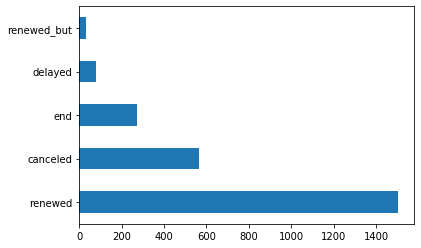

In [8]:
df_metacritic_infered_status.status.value_counts().plot.barh()

In [9]:
def clean_season_name(df):
    df_clean = df.copy()
    df_clean['season'].replace({
        r".*SEASON\s*(\d+).*": r"\1",
        r".*SEASONS\s*\d+\s*/\s*(\d+).*": r"\1",
        r".*S\s*(\d+).*": r"\1",
        r".*SEA[.]\s*(\d+).*": r"\1",
        r".*SN[.]\s*(\d+).*": r"\1"
    }, regex=True, inplace=True)
    # deletar valores que nao sao um numero
    df_clean['season'] = np.where(df_clean['season'].str.match(r"\d+", na=False), df_clean.season, np.nan)
    df_clean['season'] = df_clean['season'].astype('float')
    return df_clean

array([36., 24.,  1., 18., 10.,  2.,  6.,  3.,  4.,  5.,  7., 37., 25.,
       19., 11., 20., 38., 26., 12.,  8., 21., 22., 39., 27., 13., 23.,
       40., 28., 16., 14.,  9., 41., 29., 17., 15., 42., 30., 43., 31.,
       46., 47., 48., 32., 49., 33., 34., 50., 35., 51., 52., 53., nan])

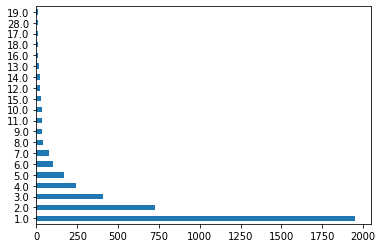

In [10]:
df_metacritic_clean_season_name = clean_season_name(df_metacritic_infered_status)
df_metacritic_clean_season_name['season'].value_counts().head(20).plot.barh()
df_metacritic_clean_season_name.season.unique()


In [11]:
# Esta funcao returnao um novo DataFrame com uma nova coluna 'lower_name', que consiste dos valores da coluna @col_name ignorando todos os caracteres que nao sao letras e numeros, e transformando o restante em lower case 
def add_lower_col(df, col_name):
    df_new = df.copy()
    df_new['lower_name'] = df_new[col_name].str.replace('[^a-zA-Z0-9]', '')
    df_new['lower_name'] = df_new['lower_name'].str.lower()
    return df_new

In [12]:
df_metacritic_clean_season_name = add_lower_col(df_metacritic_clean_season_name, 'name')

df_metacritic_aggregated = df_metacritic_clean_season_name[['lower_name', 'name', 'status', 'tv_network', 'changed_network', 'ano', 'season']].groupby(['lower_name'], as_index=False).agg({
    'name': 'last',
    'changed_network': 'any',
    'status': 'last',
    'ano': 'last',
    'tv_network': 'last',
    'season': 'last',
})


df_metacritic_aggregated.rename(
    inplace=True,
    columns={'season': 'last_info_season', 'ano': 'last_info_year'})

df_metacritic_aggregated.head()

,lower_name,name,changed_network,status,last_info_year,tv_network,last_info_season
0,100000pyramid,"$100,000 Pyramid",False,renewed,2020,ABC,5.0
1,10yearoldtom,10-Year-Old Tom,False,NaN,2020,HBO,1.0
2,112263,11/22/63,False,NaN,2015,HULU,1.0
3,12monkeys,12 Monkeys,False,end,2018,SYFY,4.0
4,13reasonswhy,13 Reasons Why,False,end,2020,NETFLIX,4.0


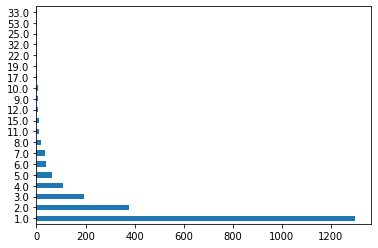

In [13]:
df_metacritic_aggregated.last_info_season.value_counts().head(20).plot.barh()

In [14]:
df_metacritic_aggregated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2206 entries, 0 to 2205
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lower_name        2206 non-null   object 
 1   name              2206 non-null   object 
 2   changed_network   2206 non-null   bool   
 3   status            1245 non-null   object 
 4   last_info_year    2206 non-null   int64  
 5   tv_network        2206 non-null   object 
 6   last_info_season  2201 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 122.8+ KB


## Juntando dados de outros datasets

`df_tvtime` contém os dados do dataset do app tvtime extraído do kaggle. Colunas importantes: `followers`, `mean_rate`, `number_of_seasons`, `runtime`

`df_streamings` contém os dados sobre series incluindo notas do "Rotten Tomatoes" e "IMDb", este também foi extraído do kaggle. Colunas importantes: `Year`, `Age`, `Rotten Tomatoes`, `IMDb`.

O código abaixo remove séries duplicadas do conjunto e agrega estes dados aos dados obtidos do metacritic, resultando no DataFrame `df_joined_datasets`.

In [15]:
df_tvtime = add_lower_col(df_tvtime, 'name')
df_tvtime_nodup = df_tvtime[['lower_name', 'name', 'network', 'followers', 'mean_rate', 'number_of_seasons', 'runtime']].groupby(['lower_name'], as_index=False).apply(lambda x: x.loc[x.followers.idxmax()])

In [16]:
df_streamings = add_lower_col(df_streamings, 'Title')
df_streaming_nodup = df_streamings[['Title', 'Year', 'Age', 'Rotten Tomatoes', 'IMDb', 'lower_name']].groupby(['lower_name'], as_index=False).apply(lambda x: x.loc[x.IMDb.fillna(0).idxmax()])

In [17]:
# Juntando datasets
df_metacritic_aggregated = add_lower_col(df_metacritic_aggregated, 'name')


df_metacritic_tvtime = pd.merge(df_metacritic_aggregated, df_tvtime_nodup, on="lower_name", how="left")
df_joined_datasets = pd.merge(df_metacritic_tvtime, df_streaming_nodup, on="lower_name", how="left")

df_joined_datasets = df_joined_datasets[['name_x', 'changed_network', 'status', 'tv_network', 'last_info_year', 'followers', 'mean_rate', 'number_of_seasons', 'runtime', 'Age', 'IMDb', 'Rotten Tomatoes', 'Year']]

# Rename some columns
df_joined_datasets.rename(
    inplace=True,
    columns={
        'followers': 'tvtime_followers',
        'mean_rate': 'tvtime_rate',
        'number_of_seasons': 'no_seasons',
        'IMDb': "imdb_rate",
        "Rotten Tomatoes": "rotten_tomatoes_rate",
        "name_x": "name",
        "runtime": "eps_duration",
        "last_info_year": "metacritc_last_info_year",
        "Year": "released_year",
        "Age": "age_rating"})

# Removendo '%' da nota do Rotten Tomatoes
df_joined_datasets['rotten_tomatoes_rate'].replace({
    r"(\d+)\%": r"\1"
}, regex=True, inplace=True)
# Transformando a nota do Rotten Tomatoes em um float
df_joined_datasets['rotten_tomatoes_rate'] = df_joined_datasets['rotten_tomatoes_rate'].astype('float')
df_joined_datasets.head()

,name,changed_network,status,tv_network,metacritc_last_info_year,tvtime_followers,tvtime_rate,no_seasons,eps_duration,age_rating,imdb_rate,rotten_tomatoes_rate,released_year
0,"$100,000 Pyramid",False,renewed,ABC,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10-Year-Old Tom,False,NaN,HBO,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11/22/63,False,NaN,HULU,2015,NaN,NaN,NaN,NaN,18+,8.2,80.0,2016.0
3,12 Monkeys,False,end,SYFY,2018,242876.0,4.73,4.0,45.0,16+,7.7,88.0,2015.0
4,13 Reasons Why,False,end,NETFLIX,2020,3631287.0,4.64,3.0,60.0,18+,7.8,39.0,2017.0


## Juntando informações sobre premiações

Os datasets `df_award_emmy` e `df_award_goldenglobe` contêm dados sobre premiações de filmes e séries. Ambos contam com a colunas: `nominee`, que possui o nome da produção; `win`, que é `True` se a produção ganhou o prêmio.

O código abaixo calcula quantas premiações as produções foram nomeadas e quantas destas foram conquistas, em seguida este dados são integrados ao DataFrame com os dados sobre as séries (`df_joined_datasets`) em um DataFrame final com todos os dados (`df_tv_shows`).

In [18]:
df_award_emmy = add_lower_col(df_award_emmy, 'nominee')
df_award_goldenglobe = add_lower_col(df_award_goldenglobe, 'nominee')
df_emmy_agg = df_award_emmy.groupby(['lower_name'], as_index=False).agg({
    'win': ['count', 'sum'],
    'nominee': 'last'
})
df_goldenglobe_agg = df_award_goldenglobe.groupby(['lower_name'],as_index=False).agg({
    'win': ['count', 'sum'],
    'nominee': 'last'
})

df_awards_joined = pd.merge(df_emmy_agg, df_goldenglobe_agg, on='lower_name', how='outer')
df_awards_joined.head()


lower_name win_x       \
                                        count  sum   
0                       100centrestreet   1.0  0.0   
1                100yearsofhopeandhumor   1.0  0.0   
2          102minutesthatchangedamerica   4.0  3.0   
3                                   105   1.0  0.0   
4  10daysthatunexpectedlychangedamerica   1.0  1.0   

                                   nominee_x win_y     nominee_y  
                                        last count sum      last  
0                          100 Centre Street   NaN NaN       NaN  
1                100 Years Of Hope And Humor   NaN NaN       NaN  
2           102 Minutes That Changed America   NaN NaN       NaN  
3                                       10.5   NaN NaN       NaN  
4  10 Days That Unexpectedly Changed America   NaN NaN       NaN

In [19]:
df_awards_count = pd.DataFrame(columns=['nominee', 'awards_won', 'awards_nominated'])
df_awards_count['nominee'] = np.where(df_awards_joined['nominee_y']['last'].isnull(), df_awards_joined['nominee_x']['last'], df_awards_joined['nominee_y']['last'])
df_awards_count['awards_nominated'] = df_awards_joined['win_x']['count'].fillna(0) + df_awards_joined['win_y']['count'].fillna(0)
df_awards_count['awards_won'] = df_awards_joined['win_x']['sum'].fillna(0) + df_awards_joined['win_y']['sum'].fillna(0)

df_awards_count.head()

,nominee,awards_won,awards_nominated
0,100 Centre Street,0.0,1.0
1,100 Years Of Hope And Humor,0.0,1.0
2,102 Minutes That Changed America,3.0,4.0
3,10.5,0.0,1.0
4,10 Days That Unexpectedly Changed America,1.0,1.0


In [20]:
df_tv_shows = pd.merge(add_lower_col(df_joined_datasets, 'name'), add_lower_col(df_awards_count, 'nominee'), on="lower_name", how="left")
df_tv_shows.drop(columns=["nominee", "lower_name"], inplace=True)

df_tv_shows.head()

,name,changed_network,status,tv_network,metacritc_last_info_year,tvtime_followers,tvtime_rate,no_seasons,eps_duration,age_rating,imdb_rate,rotten_tomatoes_rate,released_year,awards_won,awards_nominated
0,"$100,000 Pyramid",False,renewed,ABC,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10-Year-Old Tom,False,NaN,HBO,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11/22/63,False,NaN,HULU,2015,NaN,NaN,NaN,NaN,18+,8.2,80.0,2016.0,0.0,1.0
3,12 Monkeys,False,end,SYFY,2018,242876.0,4.73,4.0,45.0,16+,7.7,88.0,2015.0,NaN,NaN
4,13 Reasons Why,False,end,NETFLIX,2020,3631287.0,4.64,3.0,60.0,18+,7.8,39.0,2017.0,0.0,1.0


In [21]:
df_tv_shows.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2206 entries, 0 to 2205
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      2206 non-null   object 
 1   changed_network           2206 non-null   bool   
 2   status                    1245 non-null   object 
 3   tv_network                2206 non-null   object 
 4   metacritc_last_info_year  2206 non-null   int64  
 5   tvtime_followers          1377 non-null   float64
 6   tvtime_rate               1377 non-null   float64
 7   no_seasons                1377 non-null   float64
 8   eps_duration              1377 non-null   float64
 9   age_rating                902 non-null    object 
 10  imdb_rate                 1031 non-null   float64
 11  rotten_tomatoes_rate      607 non-null    float64
 12  released_year             1036 non-null   float64
 13  awards_won                362 non-null    float64
 14  awards_n

# PRE PROCESSAMENTO 1


#### Fazendo imputação básica através do conhecimento prévio do dataset

1. Quando não existe informações sobre premiações quer dizer que as séries não foram nomeadas.
2. Series que passaram muito tempo sem receber atualiação de status no metacritic são consideradas canceladas, consideramos 3-4 anos como o tempo máximo que uma temporada fica em produção

In [22]:
df_tv_shows_first_impute = df_tv_shows.copy()
df_tv_shows_first_impute['awards_won'].fillna(0, inplace=True)
df_tv_shows_first_impute['awards_nominated'].fillna(0, inplace=True)

# imputar 'canceled' no status de séries que não foram atualizadas nos últimos 3 anos
too_old_condition = df_tv_shows_first_impute['metacritc_last_info_year'] < 2018
df_tv_shows_first_impute['status'] = np.where(too_old_condition, df_tv_shows_first_impute['status'].fillna('canceled'), df_tv_shows_first_impute['status'])
df_tv_shows_first_impute['status'] = np.where(too_old_condition & (df_tv_shows_first_impute['status'] == 'renewed'), 'canceled', df_tv_shows_first_impute['status'])


#### Descrevendo que dados são categóricos

In [23]:
df_tv_shows_categorical = df_tv_shows_first_impute.copy()

df_tv_shows_categorical.status = df_tv_shows_categorical.status.astype('category')
df_tv_shows_categorical.age_rating = df_tv_shows_categorical.age_rating.astype('category')

df_tv_shows_categorical.metacritc_last_info_year =  df_tv_shows_categorical.metacritc_last_info_year.astype('category')

df_tv_shows_categorical.awards_nominated =  df_tv_shows_categorical.awards_nominated.astype('category')
df_tv_shows_categorical.awards_won =  df_tv_shows_categorical.awards_won.astype('category')

df_tv_shows_categorical.no_seasons =  df_tv_shows_categorical.no_seasons.astype('category')

#epi de 20 min geralmente comedia, 45/60 drama 
# df_tv_shows_categorical.eps_duration =  df_tv_shows_categorical.eps_duration.astype('category')
df_tv_shows_categorical.tv_network = df_tv_shows_categorical.tv_network.astype('category')

df_tv_shows_categorical.released_year = df_tv_shows_categorical.released_year.astype('category')


In [24]:
df_tv_shows_categorical.tv_network.cat.categories

Index(['ABC', 'AMAZON', 'AMC', 'APPLE', 'CBS', 'DISNEY', 'FOX', 'FREEF', 'FX',
       'HBO', 'HULU', 'IFC', 'MTV', 'NBC', 'NETFLIX', 'SHOWTIME', 'STRZ',
       'SYFY', 'TBS', 'THE CW', 'TNT', 'TVL', 'USA', 'YHOO', 'YT'],
      dtype='object')

In [25]:
# usando info pra mostrar o memory usage diminuindo

print(df_tv_shows.info(),'\n')
print(df_tv_shows_categorical.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2206 entries, 0 to 2205
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      2206 non-null   object 
 1   changed_network           2206 non-null   bool   
 2   status                    1245 non-null   object 
 3   tv_network                2206 non-null   object 
 4   metacritc_last_info_year  2206 non-null   int64  
 5   tvtime_followers          1377 non-null   float64
 6   tvtime_rate               1377 non-null   float64
 7   no_seasons                1377 non-null   float64
 8   eps_duration              1377 non-null   float64
 9   age_rating                902 non-null    object 
 10  imdb_rate                 1031 non-null   float64
 11  rotten_tomatoes_rate      607 non-null    float64
 12  released_year             1036 non-null   float64
 13  awards_won                362 non-null    float64
 14  awards_n

### Valores Ausentes

#### usaremos o KNN do fancyimpute 
[Github](https://github.com/iskandr/fancyimpute) 

A variety of matrix completion and imputation algorithms implemented in Python 3.6.

```pip install fancyimpute```

In [26]:
# Ajeitando o dataframe para poder usar como input no KNN
df_knn_input = df_tv_shows_categorical.drop(columns=['name'])

df_knn_input.drop(columns=[])
df_knn_input.status = df_knn_input.status.cat.codes
df_knn_input.age_rating = df_knn_input.age_rating.cat.codes
df_knn_input.metacritc_last_info_year =  df_knn_input.metacritc_last_info_year.cat.codes
df_knn_input.awards_nominated =  df_knn_input.awards_nominated.cat.codes
df_knn_input.awards_won =  df_knn_input.awards_won.cat.codes
df_knn_input.no_seasons =  df_knn_input.no_seasons.cat.codes
# df_knn_input.eps_duration =  df_knn_input.eps_duration.cat.codes
df_knn_input.tv_network =  df_knn_input.tv_network.cat.codes
df_knn_input.released_year = df_knn_input.released_year.cat.codes

In [30]:
from fancyimpute import KNN
df_knn = KNN(k=3).fit_transform(df_knn_input)

Imputing row 1/2206 with 5 missing, elapsed time: 2.411
Imputing row 101/2206 with 2 missing, elapsed time: 2.426
Imputing row 201/2206 with 5 missing, elapsed time: 2.442
Imputing row 301/2206 with 5 missing, elapsed time: 2.459
Imputing row 401/2206 with 1 missing, elapsed time: 2.475
Imputing row 501/2206 with 0 missing, elapsed time: 2.495
Imputing row 601/2206 with 0 missing, elapsed time: 2.510
Imputing row 701/2206 with 0 missing, elapsed time: 2.526
Imputing row 801/2206 with 0 missing, elapsed time: 2.540
Imputing row 901/2206 with 0 missing, elapsed time: 2.556
Imputing row 1001/2206 with 4 missing, elapsed time: 2.571
Imputing row 1101/2206 with 1 missing, elapsed time: 2.586
Imputing row 1201/2206 with 1 missing, elapsed time: 2.601
Imputing row 1301/2206 with 2 missing, elapsed time: 2.617
Imputing row 1401/2206 with 5 missing, elapsed time: 2.632
Imputing row 1501/2206 with 2 missing, elapsed time: 2.646
Imputing row 1601/2206 with 1 missing, elapsed time: 2.661
Imputing 

In [31]:
df_knn_result = pd.DataFrame(data=df_knn[0:,0:],columns=['changed_network', 'status', 'tv_network', 'metacritc_last_info_year', 'tvtime_followers', 'tvtime_rate', 'no_seasons', 'eps_duration', 'age_rating', 'imdb_rate', 'rotten_tomatoes_rate', 'released_year', 'awards_won', 'awards_nominated'])

df_knn_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2206 entries, 0 to 2205
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   changed_network           2206 non-null   float64
 1   status                    2206 non-null   float64
 2   tv_network                2206 non-null   float64
 3   metacritc_last_info_year  2206 non-null   float64
 4   tvtime_followers          2206 non-null   float64
 5   tvtime_rate               2206 non-null   float64
 6   no_seasons                2206 non-null   float64
 7   eps_duration              2206 non-null   float64
 8   age_rating                2206 non-null   float64
 9   imdb_rate                 2206 non-null   float64
 10  rotten_tomatoes_rate      2206 non-null   float64
 11  released_year             2206 non-null   float64
 12  awards_won                2206 non-null   float64
 13  awards_nominated          2206 non-null   float64
dtypes: float

In [41]:
# Reconstruindo o dataframe com os resultados do knn
df_tv_shows_imputed = df_knn_result.copy()
df_tv_shows_imputed.insert(0, 'name', df_tv_shows_categorical['name'])

df_tv_shows_imputed.head()

,name,changed_network,status,tv_network,metacritc_last_info_year,tvtime_followers,tvtime_rate,no_seasons,eps_duration,age_rating,imdb_rate,rotten_tomatoes_rate,released_year,awards_won,awards_nominated
0,"$100,000 Pyramid",0.0,3.0,0.0,7.0,2.815161e+02,0.000000,-1.0,0.000000,-1.0,7.389782,81.239778,-1.0,0.0,0.0
1,10-Year-Old Tom,0.0,-1.0,9.0,7.0,1.274000e+03,0.000000,-1.0,18.666667,-1.0,7.495310,77.700562,-1.0,0.0,0.0
2,11/22/63,0.0,0.0,10.0,2.0,9.677157e+03,3.487231,-1.0,39.975077,1.0,8.200000,80.000000,33.0,0.0,1.0
3,12 Monkeys,0.0,2.0,17.0,5.0,2.428760e+05,4.730000,4.0,45.000000,0.0,7.700000,88.000000,32.0,0.0,0.0
4,13 Reasons Why,0.0,2.0,14.0,7.0,3.631287e+06,4.640000,3.0,60.000000,1.0,7.800000,39.000000,34.0,0.0,1.0


### NORMALIZAÇÃO

Normalizando as notas e tv_time_followers para valores entre 0 e 1



In [33]:
def norm_col(df, col_name):
    new_df = df.copy()
    new_df[col_name + '_norm'] = (df[col_name] - df[col_name].min()) / (df[col_name].max() - df[col_name].min())
    return new_df

In [43]:
df_tv_shows_normalized = norm_col(df_tv_shows_imputed, 'tvtime_followers')
df_tv_shows_normalized = norm_col(df_tv_shows_normalized, 'tvtime_rate')
df_tv_shows_normalized = norm_col(df_tv_shows_normalized, 'imdb_rate')
df_tv_shows_normalized = norm_col(df_tv_shows_normalized, 'rotten_tomatoes_rate')

df_tv_shows_normalized.head()

,name,changed_network,status,tv_network,metacritc_last_info_year,tvtime_followers,tvtime_rate,no_seasons,eps_duration,age_rating,imdb_rate,rotten_tomatoes_rate,released_year,awards_won,awards_nominated,tvtime_followers_norm,tvtime_rate_norm,imdb_rate_norm,rotten_tomatoes_rate_norm
0,"$100,000 Pyramid",0.0,3.0,0.0,7.0,2.815161e+02,0.000000,-1.0,0.000000,-1.0,7.389782,81.239778,-1.0,0.0,0.0,0.000025,0.000000,0.725946,0.800423
1,10-Year-Old Tom,0.0,-1.0,9.0,7.0,1.274000e+03,0.000000,-1.0,18.666667,-1.0,7.495310,77.700562,-1.0,0.0,0.0,0.000240,0.000000,0.739651,0.762772
2,11/22/63,0.0,0.0,10.0,2.0,9.677157e+03,3.487231,-1.0,39.975077,1.0,8.200000,80.000000,33.0,0.0,1.0,0.002060,0.697446,0.831169,0.787234
3,12 Monkeys,0.0,2.0,17.0,5.0,2.428760e+05,4.730000,4.0,45.000000,0.0,7.700000,88.000000,32.0,0.0,0.0,0.052553,0.946000,0.766234,0.872340
4,13 Reasons Why,0.0,2.0,14.0,7.0,3.631287e+06,4.640000,3.0,60.000000,1.0,7.800000,39.000000,34.0,0.0,1.0,0.786227,0.928000,0.779221,0.351064


### DISCRETIZAÇÃO

Discretizando o valor da duração do episódio.
Estes intervalos foram especificados através do conhecimento prévio dos dados.

count    2206.000000
mean       35.437420
std        18.939261
min         0.000000
25%        25.000000
50%        35.000000
75%        45.000000
max       240.000000
Name: eps_duration, dtype: float64


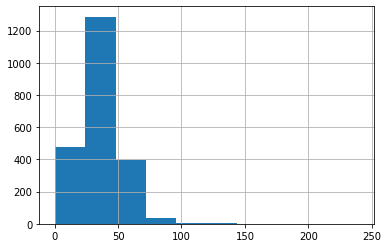

In [55]:
print(df_tv_shows_normalized.eps_duration.describe())
df_tv_shows_normalized.eps_duration.hist()

normal       1107
short        1024
long           66
very_long       9
Name: eps_duration_dist, dtype: int64


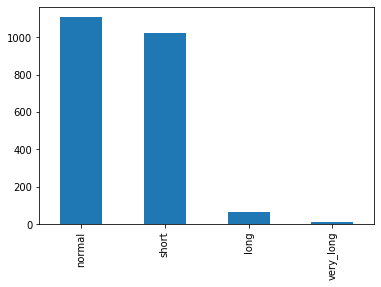

In [67]:
df_tv_shows_dist = df_tv_shows_normalized.copy()
# cria intervalos: [(-0.0005, 30], (30, 60], (60, 100], (100, 300]])
# estes intervalos foram especificados através do conhecimento dos dados
df_tv_shows_dist['eps_duration_dist'] = pd.cut(df_tv_shows_dist['eps_duration'], bins=[-0.0005, 30, 60, 100, 300], labels=['short', 'normal', 'long', 'very_long'])
print(df_tv_shows_dist.eps_duration_dist.value_counts())
df_tv_shows_dist.eps_duration_dist.value_counts().plot.bar()

#  PRE PROCESSAMENTO 2

### DETECÇÃO DE OUTLIERS
 
Remover linhas que tem duração `very_long`, a partir do conhecimento prévio dos dados entendemos que estas não são séries. Ex: 'The Lord of the Rings', 'Leaving Neverland'.

Método escolhido: `LocalOutlierFactor`

In [68]:
df_tv_shows_dist[df_tv_shows_dist['eps_duration_dist'] == 'very_long']

,name,changed_network,status,tv_network,metacritc_last_info_year,tvtime_followers,tvtime_rate,no_seasons,eps_duration,age_rating,imdb_rate,rotten_tomatoes_rate,released_year,awards_won,awards_nominated,tvtime_followers_norm,tvtime_rate_norm,imdb_rate_norm,rotten_tomatoes_rate_norm,eps_duration_dist
306,Catastrophe,0.0,2.0,1.0,5.0,20693.990068,4.089638,-1.0,116.895416,1.0,8.200000,98.000000,32.0,0.0,2.0,0.004445,0.817928,0.831169,0.978723,very_long
933,Leaving Neverland,0.0,2.0,9.0,5.0,11544.000000,4.560000,1.0,120.000000,-1.0,7.419765,67.866524,-1.0,1.0,5.0,0.002464,0.912000,0.729840,0.658155,very_long
971,Long Strange Trip,0.0,2.0,1.0,4.0,237.000000,4.070000,1.0,240.000000,1.0,8.200000,81.471571,34.0,0.0,0.0,0.000016,0.814000,0.831169,0.802889,very_long
1087,Messiah,0.0,0.0,14.0,6.0,233.000000,3.930000,5.0,120.000000,1.0,7.700000,44.000000,37.0,0.0,0.0,0.000015,0.786000,0.766234,0.404255,very_long
1153,Mystery Science Theater 3000,0.0,0.0,14.0,5.0,4755.000000,3.910000,12.0,120.000000,2.0,8.500000,80.000000,9.0,0.0,2.0,0.000994,0.782000,0.870130,0.787234,very_long
1570,Taken,0.0,0.0,13.0,4.0,17656.000000,4.200000,1.0,120.000000,0.0,6.600000,32.000000,34.0,0.0,1.0,0.003787,0.840000,0.623377,0.276596,very_long
1722,The Grand Tour,0.0,3.0,1.0,5.0,4366.340469,4.145967,-1.0,140.945483,0.0,8.700000,66.000000,33.0,0.0,0.0,0.000910,0.829193,0.896104,0.638298,very_long
1784,The Lord of the Rings,0.0,3.0,1.0,7.0,7819.000000,4.920000,1.0,120.000000,-1.0,7.094142,66.130523,-1.0,0.0,0.0,0.001657,0.984000,0.687551,0.639686,very_long
2082,Vanity Fair,0.0,2.0,1.0,5.0,1161.265151,4.169180,-1.0,113.010177,-1.0,7.300000,88.000000,35.0,0.0,0.0,0.000216,0.833836,0.714286,0.872340,very_long


In [37]:

df_dist.tvtime_rate_dist =  df_dist.tvtime_rate_dist.cat.codes
df_dist.imdb_rate_dist = df_dist.imdb_rate_dist.cat.codes
df_dist.rotten_tomatoes_rate_dist = df_dist.rotten_tomatoes_rate_dist.cat.codes

In [38]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=10)
scores = clf.fit_predict(df_dist)

In [39]:
df_dist['outliers'] = scores
df_dist.head()

,changed_network,status,tv_network,metacritc_last_info_year,tvtime_followers,tvtime_rate,no_seasons,eps_duration,age_rating,imdb_rate,rotten_tomatoes_rate,released_year,awards_won,awards_nominated,tvtime_followers_norm,tvtime_rate_dist,imdb_rate_dist,rotten_tomatoes_rate_dist,outliers
0,0.0,3.0,0.0,7.0,2.815161e+02,0.000000,-1.0,0.000000,-1.0,7.389782,81.239778,-1.0,0.0,0.0,0.000025,0,3,4,-1
1,0.0,-1.0,9.0,7.0,1.274000e+03,0.000000,-1.0,18.666667,-1.0,7.495310,77.700562,-1.0,0.0,0.0,0.000240,0,3,3,1
2,0.0,0.0,10.0,2.0,9.677157e+03,3.487231,-1.0,39.975077,1.0,8.200000,80.000000,33.0,0.0,1.0,0.002060,3,4,3,1
3,0.0,2.0,17.0,5.0,2.428760e+05,4.730000,4.0,45.000000,0.0,7.700000,88.000000,32.0,0.0,0.0,0.052553,4,3,4,1
4,0.0,2.0,14.0,7.0,3.631287e+06,4.640000,3.0,60.000000,1.0,7.800000,39.000000,34.0,0.0,1.0,0.786227,4,3,1,1


In [40]:
df_no_outliers = df_dist.copy()

df_no_outliers.insert(0, 'name', df_final_pre_proc['name'])

df_no_outliers = df_no_outliers[df_no_outliers['outliers'] != -1]

NameError: name 'df_final_pre_proc' is not defined

In [464]:
df_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2085 entries, 0 to 2205
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   name                       2085 non-null   object 
 1   changed_network            2085 non-null   float64
 2   status                     2085 non-null   float64
 3   tv_network                 2085 non-null   float64
 4   metacritc_last_info_year   2085 non-null   float64
 5   tvtime_followers           2085 non-null   float64
 6   tvtime_rate                2085 non-null   float64
 7   no_seasons                 2085 non-null   float64
 8   eps_duration               2085 non-null   float64
 9   age_rating                 2085 non-null   float64
 10  imdb_rate                  2085 non-null   float64
 11  rotten_tomatoes_rate       2085 non-null   float64
 12  released_year              2085 non-null   float64
 13  awards_won                 2085 non-null   float

# ESTATÍSTICAS DESCRITIVAS

# TESTE DE HIPOTESE

In [465]:
from scipy import stats

stats.mannwhitneyu(df_no_outliers[df_no_outliers['status'] == 0]['tvtime_followers'], df_no_outliers[df_no_outliers['status'] == 3]['tvtime_followers'])

MannwhitneyuResult(statistic=113112.5, pvalue=0.11295936286897579)

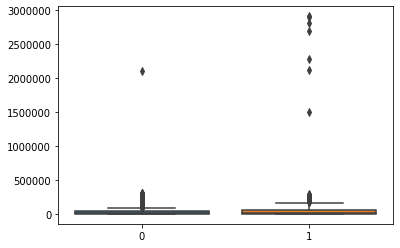

In [466]:
import seaborn as sns
data1 = df_no_outliers[df_no_outliers['status'] == 0]['tvtime_followers']
data2 = df_no_outliers[df_no_outliers['status'] == 3]['tvtime_followers']

sns.boxplot(data=[data1, data2])